In [2]:
import community
import numpy as np
import pandas as pd
import networkx as nx
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

import warnings
# Suppress warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

Data Cleaning and Pre-Processing

In [4]:
def load_graph(file_path):
    edges = []
    with open(file_path) as f:
        lines = f.readlines()
        for line in lines[4:]:
            edges.append(line.strip().split())
    G = nx.DiGraph()
    G.add_edges_from(edges)
    return G

In [5]:
def parse_admin_data(filename):
    admin = {}
    nodes = []
    labels = []
    date = {}

    with open(filename, 'r') as file:
        lines = file.readlines()

        for line in lines:
            l = line.strip().split()
            if len(l) > 0:
                if l[0] == "E":
                    a = l[1]
                    labels.append(l[1])
                if l[0] == "T":
                    d = " ".join(l[1:])
                    d = datetime.strptime(d, "%Y-%m-%d %H:%M:%S")
                if l[0] == "U":
                    if l[1] in date:
                        if d > date[l[1]]:
                            admin[l[1]] = a
                            date[l[1]] = d
                    else:
                        admin[l[1]] = a
                        date[l[1]] = d
                    nodes.append(l[1])
    return admin, nodes, labels

filename = 'wikiElec.ElecBs3.txt\wikiElec.ElecBs3.txt'
admin, nodes, labels = parse_admin_data(filename)

Community Detection

In [6]:
def louvain_community_detection(G):
    G_undirected = G.to_undirected()
    partition = community.best_partition(G_undirected)
    return partition

def label_propagation_community_detection(G):
    G_undirected = G.to_undirected()
    communities = nx.algorithms.community.label_propagation.label_propagation_communities(G_undirected)
    community_dict = {}
    for community_id, community in enumerate(communities):
        for node in community:
            community_dict[node] = community_id
    return community_dict

In [7]:
file_path = "wiki-Vote.txt\Wiki-Vote.txt"  
G = load_graph(file_path)

partition_louvain = louvain_community_detection(G)
communities_label_propagation = label_propagation_community_detection(G)

print("Louvain Community Detection Result:", partition_louvain)
print("Label Propagation Communities:", list(communities_label_propagation))

Louvain Community Detection Result: {'30': 4, '1412': 4, '3352': 15, '5254': 2, '5543': 2, '7478': 2, '3': 4, '28': 4, '39': 4, '54': 4, '108': 4, '152': 4, '178': 4, '182': 4, '214': 4, '271': 4, '286': 4, '300': 4, '348': 4, '349': 4, '371': 4, '567': 4, '581': 4, '584': 4, '586': 4, '590': 4, '604': 4, '611': 4, '8283': 4, '25': 4, '6': 4, '8': 4, '19': 4, '23': 4, '29': 4, '33': 4, '35': 4, '50': 4, '55': 4, '75': 4, '80': 4, '86': 4, '94': 4, '127': 4, '154': 4, '192': 4, '224': 4, '226': 4, '246': 4, '252': 4, '255': 4, '257': 4, '261': 4, '273': 4, '280': 4, '282': 4, '299': 4, '302': 4, '306': 4, '308': 4, '310': 4, '322': 4, '325': 4, '339': 4, '356': 4, '358': 4, '363': 4, '370': 4, '373': 4, '377': 4, '379': 4, '407': 4, '415': 4, '422': 4, '428': 4, '439': 4, '488': 4, '514': 4, '545': 4, '549': 4, '560': 4, '592': 4, '600': 4, '645': 4, '650': 4, '659': 4, '664': 4, '667': 4, '673': 4, '675': 4, '696': 4, '706': 4, '723': 4, '739': 4, '756': 4, '857': 4, '864': 4, '893': 4

In [8]:
print(f"Number of communities in Louvian Community Detection: {len(np.unique(list(partition_louvain.values())))}")
print(f"Number of communities in Label Propagation Community Detection: {len(np.unique(list(communities_label_propagation.values())))}")

Number of communities in Louvian Community Detection: 31
Number of communities in Label Propagation Community Detection: 38


Network Visulization

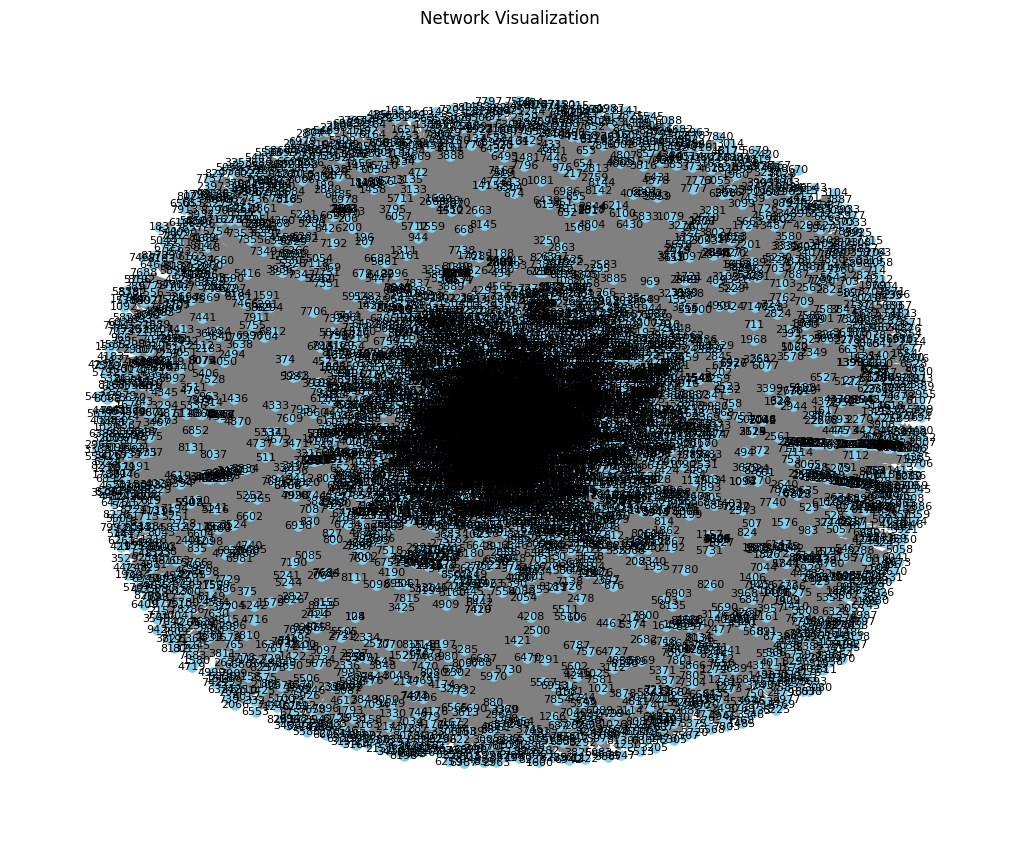

In [8]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50, edge_color='gray', linewidths=0.5, font_size=8)
plt.title('Network Visualization')
plt.show()

Feature Engineering

In [9]:
# Calculate various centrality measures
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

pagerank_scores = nx.pagerank(G)

In [10]:
network_df = pd.DataFrame({
    'Node': list(G.nodes()),
    'Degree Centrality': [degree_centrality[node] for node in G.nodes()],
    'Closeness Centrality': [closeness_centrality[node] for node in G.nodes()],
    'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes()],
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes()],
    'Indegree': [in_degrees[node] for node in G.nodes()],
    'Outdegree': [out_degrees[node] for node in G.nodes()],
    'PageRank': [pagerank_scores[node] for node in G.nodes()],
})

network_df['Class Label'] = network_df['Node'].map(admin)
network_df['Class Label'] = network_df['Class Label'].fillna('2')

In [11]:
network_df.head()

,Node,Degree Centrality,Closeness Centrality,Betweenness Centrality,Eigenvector Centrality,Indegree,Outdegree,PageRank,Class Label
0,30,0.003936,0.212189,0.000059,0.002351,23,5,0.000173,1
1,1412,0.004076,0.200967,0.000000,0.001490,29,0,0.000814,1
2,3352,0.075485,0.274980,0.004332,0.086794,264,273,0.001785,1
3,5254,0.041889,0.276567,0.001528,0.078512,265,33,0.002150,0
4,5543,0.039640,0.261771,0.002202,0.046956,145,137,0.001051,1


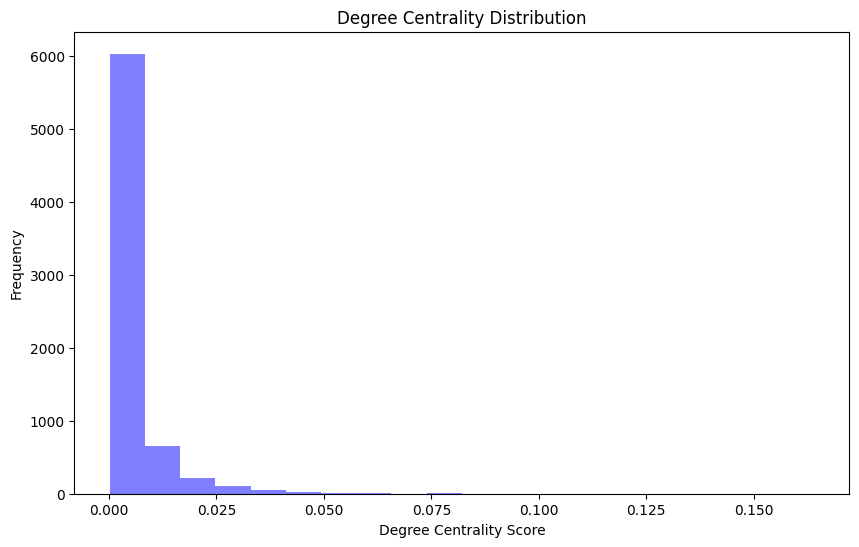

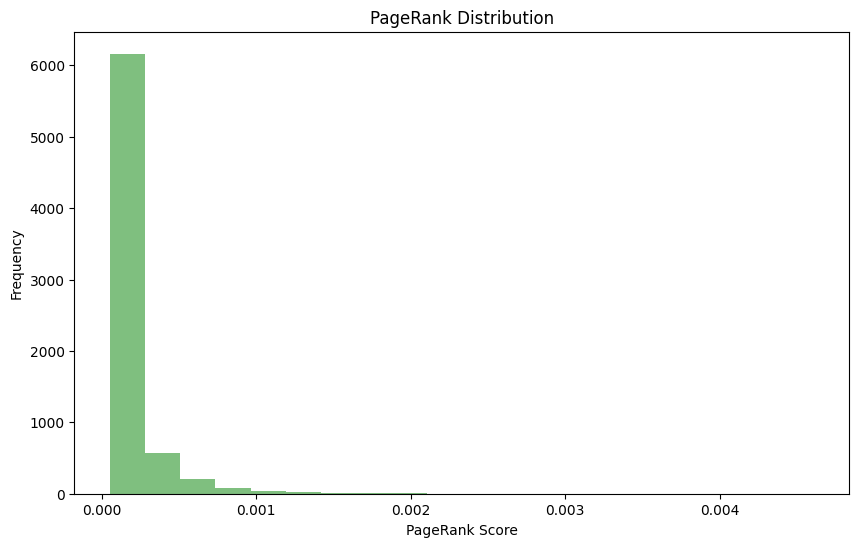

In [13]:
# Degree centrality visualization
plt.figure(figsize=(10, 6))
plt.hist(network_df['Degree Centrality'], bins=20, alpha=0.5, color='b')
plt.title("Degree Centrality Distribution")
plt.xlabel("Degree Centrality Score")
plt.ylabel("Frequency")
plt.show()

# PageRank visualization
plt.figure(figsize=(10, 6))
plt.hist(network_df['PageRank'], bins=20, alpha=0.5, color='g')
plt.title("PageRank Distribution")
plt.xlabel("PageRank Score")
plt.ylabel("Frequency")
plt.show()


Model Training

In [12]:
def train_test_split_and_standardize(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

def knn_classification(X_train, X_test, y_train, y_test, n_neighbors=5):
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_model.fit(X_train, y_train)
    knn_pred = knn_model.predict(X_test)
    knn_accuracy = accuracy_score(y_test, knn_pred)
    knn_classification_report = classification_report(y_test, knn_pred)
    return knn_pred, knn_accuracy, knn_classification_report, knn_model

def svm_classification(X_train, X_test, y_train, y_test, kernel='linear'):
    svm_model = SVC(kernel=kernel)
    svm_model.fit(X_train, y_train)
    svm_pred = svm_model.predict(X_test)
    svm_accuracy = accuracy_score(y_test, svm_pred)
    svm_classification_report = classification_report(y_test, svm_pred)
    return svm_pred, svm_accuracy, svm_classification_report, svm_model

def random_forest_classification(X_train, X_test, y_train, y_test, n_estimators=100, random_state=42):
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    rf_classifier.fit(X_train, y_train)
    rf_pred = rf_classifier.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    rf_classification_report = classification_report(y_test, rf_pred)
    return rf_pred, rf_accuracy, rf_classification_report, rf_classifier

def gbm_classification(X_train, X_test, y_train, y_test, n_estimators=100, learning_rate=0.1, random_state=42):
    gbm_classifier = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=random_state)
    gbm_classifier.fit(X_train, y_train)
    gbm_pred = gbm_classifier.predict(X_test)
    gbm_accuracy = accuracy_score(y_test, gbm_pred)
    gbm_classification_report = classification_report(y_test, gbm_pred)
    return gbm_pred, gbm_accuracy, gbm_classification_report, gbm_classifier

In [13]:
def calculate_nmi(labels_knn, labels_ground_truth):
    nmi = normalized_mutual_info_score(labels_knn, labels_ground_truth)
    return nmi

In [14]:
X = network_df.drop(columns=["Node", "Class Label"])
y = network_df["Class Label"]
X_train, X_test, y_train, y_test = train_test_split_and_standardize(X, y)


knn_pred, knn_accuracy, knn_classification_report, knn_model = knn_classification(X_train, X_test, y_train, y_test)
print("KNN Accuracy:", knn_accuracy)
print("KNN Classification Report:")
print(knn_classification_report)
print()

svm_pred, svm_accuracy, svm_classification_report, svm_model = svm_classification(X_train, X_test, y_train, y_test)
print("SVM Accuracy:", svm_accuracy)
print("SVM Classification Report:")
print(svm_classification_report)

rf_pred, rf_accuracy, rf_classification_report, rf_model = random_forest_classification(X_train, X_test, y_train, y_test)
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Classification Report:")
print(rf_classification_report)

gbm_pred, gbm_accuracy, gbm_classification_report, gbm_model = gbm_classification(X_train, X_test, y_train, y_test)
print("Gradient Boosting Machine Accuracy:", gbm_accuracy)
print("Gradient Boosting Machine Classification Report:")
print(gbm_classification_report)

KNN Accuracy: 0.9283204497540407
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.72      0.77       237
           1       0.78      0.86      0.82       257
           2       1.00      1.00      1.00       929

    accuracy                           0.93      1423
   macro avg       0.87      0.86      0.86      1423
weighted avg       0.93      0.93      0.93      1423


SVM Accuracy: 0.921293042867182
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.69      0.75       237
           1       0.78      0.85      0.81       257
           2       0.99      1.00      0.99       929

    accuracy                           0.92      1423
   macro avg       0.86      0.85      0.85      1423
weighted avg       0.92      0.92      0.92      1423

Random Forest Accuracy: 0.9304286718200984
Random Forest Classification Report:
              precision    recall  f1-

In [15]:
print(f"NMI of the Communities detected by KNN: {calculate_nmi(knn_pred, y_test)}")
print(f"NMI of the Communities detected by KNN: {calculate_nmi(svm_pred, y_test)}")
print(f"NMI of the Communities detected by KNN: {calculate_nmi(rf_pred, y_test)}")
print(f"NMI of the Communities detected by KNN: {calculate_nmi(gbm_pred, y_test)}")

NMI of the Communities detected by KNN: 0.7890603909921241
NMI of the Communities detected by KNN: 0.7645522806482313
NMI of the Communities detected by KNN: 0.8068833627664364
NMI of the Communities detected by KNN: 0.8222146586572482


Model Training with Community detection results (Louvain)

In [16]:
network_df['Community'] = network_df['Node'].map(partition_louvain)
network_df['Community'].unique()

array([ 3,  1,  2,  4,  8, 10, 16, 21, 22, 26, 28, 25, 27,  0,  5,  6,  7,
        9, 11, 12, 13, 14, 15, 17, 18, 19, 20, 23, 24], dtype=int64)

In [17]:
X = network_df.drop(columns=["Node", "Class Label"])
y = network_df["Class Label"]
X_train, X_test, y_train, y_test = train_test_split_and_standardize(X, y)


knn_pred, knn_accuracy, knn_classification_report, knn_model = knn_classification(X_train, X_test, y_train, y_test)
print("KNN Accuracy:", knn_accuracy)
print("KNN Classification Report:")
print(knn_classification_report)
print()

svm_pred, svm_accuracy, svm_classification_report, svm_model = svm_classification(X_train, X_test, y_train, y_test)
print("SVM Accuracy:", svm_accuracy)
print("SVM Classification Report:")
print(svm_classification_report)

rf_pred, rf_accuracy, rf_classification_report, rf_model = random_forest_classification(X_train, X_test, y_train, y_test)
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Classification Report:")
print(rf_classification_report)

gbm_pred, gbm_accuracy, gbm_classification_report, gbm_model = gbm_classification(X_train, X_test, y_train, y_test)
print("Gradient Boosting Machine Accuracy:", gbm_accuracy)
print("Gradient Boosting Machine Classification Report:")
print(gbm_classification_report)

KNN Accuracy: 0.9198875614898102
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.66      0.73       237
           1       0.75      0.89      0.82       257
           2       0.99      1.00      0.99       929

    accuracy                           0.92      1423
   macro avg       0.86      0.85      0.85      1423
weighted avg       0.92      0.92      0.92      1423


SVM Accuracy: 0.921293042867182
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.69      0.75       237
           1       0.78      0.85      0.81       257
           2       0.99      1.00      0.99       929

    accuracy                           0.92      1423
   macro avg       0.86      0.85      0.85      1423
weighted avg       0.92      0.92      0.92      1423

Random Forest Accuracy: 0.932536893886156
Random Forest Classification Report:
              precision    recall  f1-s

In [18]:
print(f"NMI of the Communities detected by KNN: {calculate_nmi(knn_pred, y_test)}")
print(f"NMI of the Communities detected by KNN: {calculate_nmi(svm_pred, y_test)}")
print(f"NMI of the Communities detected by KNN: {calculate_nmi(rf_pred, y_test)}")
print(f"NMI of the Communities detected by KNN: {calculate_nmi(gbm_pred, y_test)}")

NMI of the Communities detected by KNN: 0.7598810439220438
NMI of the Communities detected by KNN: 0.7645522806482313
NMI of the Communities detected by KNN: 0.8110016142455223
NMI of the Communities detected by KNN: 0.8227163208591532


Model Training with Community detection results (Label Propagation)

In [19]:
network_df['Community'] = network_df['Node'].map(communities_label_propagation)
network_df['Community'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37], dtype=int64)

In [20]:
X = network_df.drop(columns=["Node", "Class Label"])
y = network_df["Class Label"]
X_train, X_test, y_train, y_test = train_test_split_and_standardize(X, y)


knn_pred, knn_accuracy, knn_classification_report, knn_model = knn_classification(X_train, X_test, y_train, y_test)
print("KNN Accuracy:", knn_accuracy)
print("KNN Classification Report:")
print(knn_classification_report)
print()

svm_pred, svm_accuracy, svm_classification_report, svm_model = svm_classification(X_train, X_test, y_train, y_test)
print("SVM Accuracy:", svm_accuracy)
print("SVM Classification Report:")
print(svm_classification_report)

rf_pred, rf_accuracy, rf_classification_report, rf_model = random_forest_classification(X_train, X_test, y_train, y_test)
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Classification Report:")
print(rf_classification_report)

gbm_pred, gbm_accuracy, gbm_classification_report, gbm_model = gbm_classification(X_train, X_test, y_train, y_test)
print("Gradient Boosting Machine Accuracy:", gbm_accuracy)
print("Gradient Boosting Machine Classification Report:")
print(gbm_classification_report)

KNN Accuracy: 0.921293042867182
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.70      0.75       237
           1       0.78      0.86      0.82       257
           2       0.99      0.99      0.99       929

    accuracy                           0.92      1423
   macro avg       0.86      0.85      0.85      1423
weighted avg       0.92      0.92      0.92      1423


SVM Accuracy: 0.921293042867182
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.69      0.75       237
           1       0.78      0.85      0.81       257
           2       0.99      1.00      0.99       929

    accuracy                           0.92      1423
   macro avg       0.86      0.85      0.85      1423
weighted avg       0.92      0.92      0.92      1423

Random Forest Accuracy: 0.9318341531974701
Random Forest Classification Report:
              precision    recall  f1-s

In [21]:
print(f"NMI of the Communities detected by KNN: {calculate_nmi(knn_pred, y_test)}")
print(f"NMI of the Communities detected by KNN: {calculate_nmi(svm_pred, y_test)}")
print(f"NMI of the Communities detected by KNN: {calculate_nmi(rf_pred, y_test)}")
print(f"NMI of the Communities detected by KNN: {calculate_nmi(gbm_pred, y_test)}")

NMI of the Communities detected by KNN: 0.7509916532548117
NMI of the Communities detected by KNN: 0.7645522806482313
NMI of the Communities detected by KNN: 0.8096042860476637
NMI of the Communities detected by KNN: 0.8238758003158743


Graph Neural Network 

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GCNConv

In [23]:
import numpy as np
import networkx as nx
import torch

G_undirected = G.to_undirected()
adjacency_matrix = nx.adjacency_matrix(G_undirected)
adjacency_matrix_dense = adjacency_matrix.toarray()
adjacency_matrix_tensor = torch.tensor(adjacency_matrix_dense, dtype=torch.float)

In [24]:
features = network_df[['Degree Centrality', 'Closeness Centrality', 'Betweenness Centrality',
                       'Eigenvector Centrality', 'Indegree', 'Outdegree', 'PageRank']].values
labels = network_df['Class Label'].astype(int).values

In [48]:
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        x = torch.matmul(adj, x)
        x = self.linear(x)
        return F.relu(x)

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(input_dim, hidden_dim)
        self.gcn2 = GCNLayer(hidden_dim, output_dim)

    def forward(self, x, adj):
        x = self.gcn1(x, adj)
        x = self.gcn2(x, adj)
        return F.log_softmax(x, dim=1)

adjacency_matrix_tensor = torch.tensor(adjacency_matrix_dense, dtype=torch.float)
features_tensor = torch.tensor(features, dtype=torch.float)
labels_tensor = torch.tensor(labels, dtype=torch.long)
input_dim = features_tensor.shape[1]
hidden_dim = 16
output_dim = 3 
model = GCN(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

def train(model, features, adj, labels, optimizer, criterion, epochs=1000):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(features, adj)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            accuracy = calculate_accuracy(output, labels)
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Accuracy: {accuracy}')

def calculate_accuracy(output, labels):
    _, predicted = torch.max(output, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

def evaluate(model, features, adj, labels):
    model.eval()
    with torch.no_grad():
        output = model(features, adj)
        loss = criterion(output, labels)
        accuracy = calculate_accuracy(output, labels)
        print(f'Test Loss: {loss.item()}, Test Accuracy: {accuracy}')

train(model, features_tensor, adjacency_matrix_tensor, labels_tensor, optimizer, criterion)
evaluate(model, features_tensor, adjacency_matrix_tensor, labels_tensor)


Epoch 1/1000, Loss: 997.1765747070312, Accuracy: 0.16359803232607167
Epoch 11/1000, Loss: 1.0986565351486206, Accuracy: 0.16444132115249474
Epoch 21/1000, Loss: 1.097276210784912, Accuracy: 0.16936050597329586
Epoch 31/1000, Loss: 1.059644103050232, Accuracy: 0.27069571328179903
Epoch 41/1000, Loss: 1.093868613243103, Accuracy: 0.17259311314125086
Epoch 51/1000, Loss: 1.0938442945480347, Accuracy: 0.1724525650035137
Epoch 61/1000, Loss: 1.0932674407958984, Accuracy: 0.17259311314125086
Epoch 71/1000, Loss: 1.0927754640579224, Accuracy: 0.17259311314125086
Epoch 81/1000, Loss: 1.092301368713379, Accuracy: 0.1730147575544624
Epoch 91/1000, Loss: 1.0917707681655884, Accuracy: 0.17343640196767393
Epoch 101/1000, Loss: 1.0891330242156982, Accuracy: 0.17737174982431483
Epoch 111/1000, Loss: 1.0122756958007812, Accuracy: 0.2546732255797611
Epoch 121/1000, Loss: 0.8589330315589905, Accuracy: 0.4125087842586086
Epoch 131/1000, Loss: 0.7896121740341187, Accuracy: 0.4877020379479972
Epoch 141/100